In [56]:
import torch
import triton
import triton.language as tl

In [57]:
@triton.jit
def layernorm_kernel_fwd(x_ptr, output_ptr, w_ptr, b_ptr, stride, n_cols, eps, BLOCK_SIZE: tl.constexpr):
    pid = tl.program_id(axis=0)
    offsets = tl.arange(0, BLOCK_SIZE)
    x_ptrs = x_ptr + pid * stride + offsets
    mask = offsets < n_cols
    x = tl.load(x_ptrs, mask=mask, other=0.)
    mean = tl.sum(x) / n_cols
    x_minus_mean = tl.where(offsets < n_cols, x - mean, 0.)
    var = tl.sum(x_minus_mean * x_minus_mean) / n_cols
    rstd = 1 / tl.sqrt(var + eps)
    x_hat = (x - mean) * rstd
    
    w = tl.load(w_ptr + offsets, mask=mask, other=0.)
    b = tl.load(b_ptr + offsets, mask=mask, other=0.)
    output = x_hat * w + b
    tl.store(output_ptr + pid * stride + offsets, output, mask=mask)

In [58]:
def layer_norm(x, normalized_shape, weight, bias, eps):
    M, N = x.shape
    y = torch.empty_like(x)
    BLOCK_SIZE = triton.next_power_of_2(N)
    layernorm_kernel_fwd[(M,)](x, y, weight, bias, x.stride(0), N, eps, BLOCK_SIZE=BLOCK_SIZE)
    return y

In [59]:
def test_layer_norm(M, N, dtype, eps=1e-5, device='cuda'):
    x_shape = (M, N)
    w_shape = (x_shape[-1], )
    weight = torch.rand(w_shape, dtype=dtype, device=device)
    bias = torch.rand(w_shape, dtype=dtype, device=device)
    x = -2.3 + 0.5 * torch.randn(x_shape, dtype=dtype, device=device)
    y_tri = layer_norm(x, w_shape, weight, bias, eps)
    y_ref = torch.nn.functional.layer_norm(x, w_shape, weight, bias, eps).to(dtype)
    # print(y_tri)
    # print(y_ref)
    assert torch.allclose(y_tri, y_ref, atol=1e-2, rtol=0)

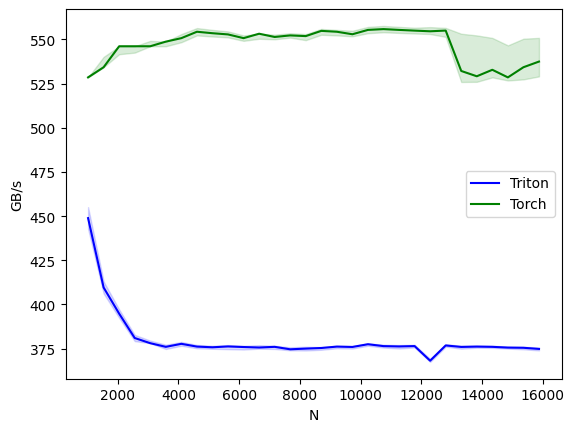

layernorm-performance:
          N      Triton       Torch
0    1024.0  448.876695  528.516136
1    1536.0  409.600010  534.260858
2    2048.0  394.795186  546.133347
3    2560.0  381.023269  546.133307
4    3072.0  378.092307  546.133325
5    3584.0  376.026237  548.746398
6    4096.0  377.729113  550.722705
7    4608.0  376.163278  554.345889
8    5120.0  375.779815  553.513489
9    5632.0  376.250515  552.834341
10   6144.0  375.923501  550.722671
11   6656.0  375.647260  553.225985
12   7168.0  376.026237  551.384622
13   7680.0  374.634152  552.269648
14   8192.0  375.027168  551.882096
15   8704.0  375.374661  554.836675
16   9216.0  376.163278  554.345889
17   9728.0  375.961344  552.923643
18  10240.0  377.511532  555.389821
19  10752.0  376.437647  555.838450
20  11264.0  376.250515  555.389836
21  11776.0  376.455524  554.980863
22  12288.0  368.179781  554.606499
23  12800.0  376.816923  555.013570
24  13312.0  375.978813  532.147419
25  13824.0  376.163268  529.148312
26  1

In [65]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # argument names to use as an x-axis for the plot
        x_vals=[512 * i for i in range(2, 32)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch'],  # possible values for `line_arg``
        line_names=[
            "Triton",
            "Torch",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="layernorm-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={'M': 4096, 'dtype': torch.float32, 'mode': 'forward'},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(M, N, dtype, provider, mode='forward', eps=1e-5, device='cuda'):
    # create data
    x_shape = (M, N)
    w_shape = (x_shape[-1], )
    weight = torch.rand(w_shape, dtype=dtype, device=device)
    bias = torch.rand(w_shape, dtype=dtype, device=device)
    x = -2.3 + 0.5 * torch.randn(x_shape, dtype=dtype, device=device)
    quantiles = [0.5, 0.2, 0.8]

    def y_fwd():
        if provider == 'torch':
            return layer_norm(x, w_shape, weight, bias, eps)
        if provider == 'triton':
            return torch.nn.functional.layer_norm(x, w_shape, weight, bias, eps)  
    
    if mode == 'forward':
        gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
        ms, min_ms, max_ms = triton.testing.do_bench(y_fwd, quantiles=quantiles, rep=500)
    
    return gbps(ms), gbps(max_ms), gbps(min_ms)

test_layer_norm(1151, 8192, torch.float32)
benchmark.run(show_plots=True, print_data=True)